# **Optiver Realized Volatility Prediction**

## **Acknowledgement**

[https://www.kaggle.com/tatudoug/stock-embedding-ffnn-features-of-the-best-lgbm/notebook](http://)  
[https://www.kaggle.com/c/optiver-realized-volatility-prediction/discussion/251277  ](http://)  

## **Define the infrastructure**

#### Import libraries and set options

In [ ]:
import sys
import glob
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import json
from pylab import rcParams
import numpy as np
from collections import defaultdict
import itertools
from IPython.display import display
import gc
from tqdm import tqdm
import cudf
from cudf import DataFrame
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import optuna
import lightgbm as lgb
import xgboost as xgb
import time
import warnings
%matplotlib inline

# Set pandas options
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")

print("Threshold:", gc.get_threshold())
print("Count:", gc.get_count())

#### Define parameters

In [ ]:
# 0 for training, 1 for inference
MODE = 0

# 1 if pretrained datasets exist at phase 1, 2 at phase 2, and so on. There are 6 phases in total.
PRETRAINED = 1

# Optiver data directory
DIR = "../input/optiver-realized-volatility-prediction/"

# csv train and test data
CSV_FILES = ['train.csv', 'test.csv']

# Parquet train and test data of order and trade books
PARQUET_FILES = {"Order Book": ['book_train.parquet', 'book_test.parquet'], 
                 "Trade Book": ['trade_train.parquet', 'trade_test.parquet']}

# Epsilon number to avoid dividing by zero error
EPSILON = sys.float_info.epsilon

# Impute values for missing items
CORRECT_DATASET = "yes"

# Seconds windows
WINDOWS = [0, 120, 240, 360, 480]

# Seed value to be used in the model
SEED = 1

## **Load and reformat data**

#### Dtype changes

In [ ]:
# Make dtype changes
def change_dtype(df, convert_dict):
    df = df.astype(convert_dict)
    return df

# Create dtype list
def make_dtype_list(df, source_dtype, target_dtype):
    try:
        source_dtype_list = list(df.select_dtypes(include=source_dtype).columns)
        dtype_dict = dict(zip(source_dtype_list, [target_dtype] * len(source_dtype_list)))
    except:
        pass
    df = change_dtype(df, dtype_dict)
    return df

#### Load and reformat the csv data

In [ ]:
%%time
def load_reformat_csv(file):
    
    print("Information about", CSV_FILES[MODE] + " data")
    print('-' * 50, '\n\n')
    df = cudf.read_csv(file)
    
    # Describe data before reformat
    print("Before reformat \n")
    display(df.info())
    print("\n")
    
    # Make dtype changes
    if MODE == 1:
        df["target"] = 0
    convert_dict = {'time_id': 'int16', 'stock_id': 'int16', 'target': 'float32'}
    df = change_dtype(df, convert_dict)
    
    # Describe data after reformat
    print("After reformat \n")
    display(df.info())
    print("\n\n")
    display(df.head())
    return df

filename = DIR + CSV_FILES[MODE]
df_csv = load_reformat_csv(filename)

#### Get the parquet data info

In [ ]:
%%time
def describe_parquet_data(key):
    
    # Retrieve the file name
    file = PARQUET_FILES[key][MODE]
    
    # Column names
    column_names = ['time_id', "stock_id"]
    
    print(file, "from", key, ":")
    print('-' * 50, '\n')
    
    # Load the parquet file
    list_order_book_file_train = glob.glob(DIR + file + "/*")
    df_parquet = cudf.read_parquet(list_order_book_file_train)
    
    # Get info about data
    display(df_parquet.info())
    print("\n")
    
    # Check if any nan values
    display(df_parquet.isnull().values.any())
    print("\n")
    
    # Get unique values in time_id and stock_id columns and put them in a list
    time_ids = sorted(df_parquet['time_id'].unique().to_array().tolist())
    stock_ids = sorted([int(file_path.split('=')[1]) for file_path in list_order_book_file_train])
    ids =[time_ids, stock_ids]

    # Find the number of records, max and min values in the column specified
    time_id_records = len(time_ids)
    stock_id_records = len(stock_ids)
    records = [time_id_records,stock_id_records]
    
    # Output the values found
    for i in range(2):
        minRecord = np.min(ids[i])
        maxRecord = np.max(ids[i])
        print(f"Number of {column_names[i]} records in {key}: {records[i]} \n Minimum {column_names[i]} record: {minRecord} \n Maximum {column_names[i]} record: {maxRecord}")
        print('\n')
        
    # Delete parquet df
    del df_parquet
        
    return time_ids, stock_ids

if MODE == 0:

    keys = ["Order Book", "Trade Book"]

    # Get order book info and time_ids, stock_ids as a list
    time_ids, stock_ids = describe_parquet_data(keys[0])

    # Get trade book info
    _, _ = describe_parquet_data(keys[1])

#### Load and reformat the parquet data

In [ ]:
%%time

# Forward fill data
def ffill(data_df, key):
    
    # Forward fill
    data_df = data_df.set_index(['time_id', 'seconds_in_bucket']).to_pandas()
    
    if key == "Order Book":
        data_df = data_df.reindex(pd.MultiIndex.from_product([data_df.index.levels[0], np.arange(0,600)], names = ['time_id', 'seconds_in_bucket']), method='ffill')
        data_df = data_df.reset_index()
        convert_dict = {'time_id': 'int16', 'seconds_in_bucket': 'int16'}
    else:
        data_df = data_df.reindex(pd.MultiIndex.from_product([data_df.index.levels[0], np.arange(0,600)], names = ['time_id', 'seconds_in_bucket']))
        # Fill nan values with 0
        data_df = data_df.fillna(0)
        data_df = data_df.reset_index()
        convert_dict = {'time_id': 'int16', 'seconds_in_bucket': 'int16', 'size': 'int32', 'order_count': 'int32'}
        
    # Make dtype changes
    data_df = change_dtype(data_df, convert_dict)

    # Convert to a cudf dataframe
    data_df = cudf.DataFrame.from_pandas(data_df)

    return data_df


# Load parquet data
def load_parquet_data(key, stockId):
    
    # Retrieve the file name
    file = PARQUET_FILES[key][MODE]
    
    # Find the file of the stock_id and create a dataframe
    df_parquet_data = cudf.read_parquet(DIR + file + "/stock_id=" + str(stockId), npartitions=1)
    df_parquet_data = ffill(df_parquet_data, key)
    
    return df_parquet_data

## **Feature Engineering**

### **Feature extraction by stock_id**

#### _stock_id_

In [ ]:
def add_stock_id(df, stockId):
    
    df['stock_id'] = stockId
    
    # Make dtype changes
    convert_dict = {'stock_id': 'int16'}
    df = change_dtype(df, convert_dict)
    
    # Reorder the columns
    cols = df.columns.tolist()
    cols = list(itertools.chain(cols[0:1], cols[-1:], cols[1:-1]))
    df = df[cols]
    
    return df

#### _high-low measure_  
<br>
Calculate `high_low_measure` from the order book for each `stock_id` and every `time_id`  

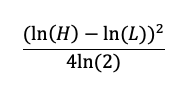

where  
`H` is the highest price  
`L` is the lowest price  

#### _density code_

In [ ]:
def calculate_density_code(x):
    if x !=0:
        return 1
    else:
        return 0

#### _density score_  

Number of seconds when at least one transaction occurred, divided by the total number of seconds in a given window

In [ ]:
def calculate_density_score(df, m):
    
    # Calculate density score by window
    df["density_score_" + str(m)] = df["density_code_" + str(m) + "_sum"] / m
    
    return df

#### _normal return by second_

Percentage change of wap from previous to the current second within a particular time_id. This is not log return.

In [ ]:
def shift_wap(window):
    for a in window:
        b = a * 1
    return b

#### _average stock log return_
<br>

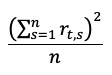

where    
    `s` represents a specific stock  
    `t` is a particular time_id  
    `r` is the log return by second of stock `s` within the time_id `t`  
    `n` is the number of seconds  

In [ ]:
def calculate_avg_log_return(df, m):
       
    # Calculate the average log return by window and assign it to a new column
    df["avg_log_return_" + str(m)] = (df["log_return_" + str(m) + "_sum"] ** 2) / m
        
    return df

#### _normal return by time_id_  

Percentage change between wap at second=1 and wap at second=599 across time_ids. This is not log return.

In [ ]:
def calculate_normal_return_by_timeid(df):
    
    return_list = []
    
    # Create a dictionary with time_id as the key and wap1 as the value
    list_000 = df[df['seconds_in_bucket']==1][["time_id", "wap1"]].to_pandas().to_dict('records')
    list_599 = df[df['seconds_in_bucket']==599][["time_id", "wap1"]].to_pandas().to_dict('records')
    dict_000 = {x['time_id']: x['wap1'] for x in list_000}
    dict_599 = {x['time_id']: x['wap1'] for x in list_599}
    
    # Calculate return
    for time_id in time_ids:
        # Check if time_id exists
        if time_id in dict_000 and time_id in dict_599:
            stock_return_by_timeid = (dict_599[time_id] / dict_000[time_id]) - 1
        else:
            stock_return_by_timeid = 0
            print("missing time_id: ", time_id, ", substitute stock_return_by_timeid: ", stock_return_by_timeid)
        return_list.append(stock_return_by_timeid)
        
    pdf = pd.DataFrame({'time_id': time_ids,'norm_return_by_timeid': return_list})                                                                                               
    
    df_temp = cudf.DataFrame.from_pandas(pdf)
    
    return df_temp

#### _realized volatility_  

In [ ]:
def calculate_realized_volatility(df, m):
    
    # Calculate realized volatility by window
    df["realized_volatility_" + str(m)] = np.sqrt(df["sqrd_log_return_" + str(m) + "_sum"])
        
    return df

#### _density-scored total trade volume_  

Total trade volume multiplied by density score

In [ ]:
def calculate_density_scored_total_trade_vol(df, m):
    
    # Calculate density-scored trade volume by window
    df["density_scored_total_trade_vol_" + str(m)] = df["trade_volume_" + str(m) + "_sum"] * df["density_score_" + str(m)]
    
    return df

#### _density-scored total orders_  

Total orders multiplied by density score

In [ ]:
def calculate_density_scored_total_orders(df, m):

    # Calculate density-scored total orders by window
    df["density_scored_total_orders_" + str(m)] = df["order_count_" + str(m) + "_sum"] * df["density_score_" + str(m)]
    
    return df

#### _max-min difference_  

Difference between maximum and minimum values

In [ ]:
def calculate_max_min_difference(df, m):

    # Calculate max-min difference by window
    for fs in features_list:
        df[fs + '_' + str(m) + '_max_min'] = df[fs + '_' + str(m) + '_max'] - df[fs + '_' + str(m) + '_min']
        
    return df

#### _kurtosis_

In [ ]:
def calculate_kurtosis(df_merged, df, window):
    
    # Calculate kurtosis by group
    df_moment = df_merged[df_merged['seconds_in_bucket'] >= window].groupby('time_id', as_index=False, sort=True)[features_list].apply(lambda x: x.kurt(skipna = True))
    
    # Rename columns
    df_moment.rename({col: col + "_" +  str(window) + "_kurt" for col in df_moment.columns.values[1:]}, axis=1, inplace=True)
    
    # Merge with the main dataframe
    df = df.merge(df_moment, how="left", on=["time_id"])
    
    # Delete dataframe
    del df_moment

    return df

#### _statistical measures of features_  

In [ ]:
# Mathematical and statistical operations
operations = ["mean", "median", "max", "min", "std"]

# Features list
features_list = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2', 'bid1_volume', 
                 'bid2_volume', 'ask1_volume', 'ask2_volume', 'price', 'size', 'wap1', 'wap2', 'trade_volume', 'order_count', 
                 'spread_ask1_bid1', 'spread_ask2_bid2', 'spread_bid1_bid2', 'spread_ask2_ask1', 'log_return', 'high_low_measure', 
                 'volume_imbalance', 'trade_volume_imbalance', 'stock_liquidity', 'wap_liquidity', 'norm_return_by_second'
                ]    

# Data dictionary
data_dict = defaultdict(list)
moment_dict = {}

for fs in features_list:
    data_dict[fs].extend(operations)
    moment_dict[fs] = "skew"
    
sum_list = ['bid1_volume', 'bid2_volume', 'ask1_volume', 'ask2_volume', 'density_code', 'trade_volume', 'order_count', 'log_return', 
            'sqrd_log_return', 'stock_liquidity', 'wap_liquidity', 'volume_imbalance', 'trade_volume_imbalance'
           ]

for fs in sum_list:
    data_dict[fs].append("sum")

display(data_dict)
print("\n")
display(moment_dict)

#### Create dataframes with statistical measures of features

In [ ]:
def create_stat_dfs(df_merged, window):
    
    # Create a dataframe filtered by seconds_in_bucket and grouped by time_id. Calculate aggregate measures by group.
    df = df_merged[df_merged['seconds_in_bucket'] >= window].groupby('time_id', as_index=False, sort=True).agg(data_dict)
    
    # Rename columns
    df.columns = [f"_{window}_".join(col) for col in df.columns.values]
    df = df.rename(columns={f"time_id_{window}_": "time_id"})
    
    return df

### **Feature engineering on stock_id**

In [ ]:
def develop_initial_features():
    
    # Define for loop terms
    start = 0
    end = len(stock_ids)
    step = 112
    
    for p in range(start, end, step):  

        # Create an empty dataframe for features
        df_initial_features = cudf.DataFrame()

        for stock_id in tqdm(stock_ids[p:p+step]):

            print('\n')
            print("processing stock_id: ", stock_id)

            # Load the order book parquet data as dataframe
            df_order = load_parquet_data("Order Book", stock_id)

            # Load the trade book parquet data as dataframe
            df_trade = load_parquet_data("Trade Book", stock_id)

            # Merge both dataframes and sort by 'seconds_in_bucket' in ascending order
            df_merged = df_order.merge(df_trade, how="left", on=["time_id", "seconds_in_bucket"])

            # Create statistics dataframe
            df_statistics = df_merged[["time_id", "seconds_in_bucket"]]

            # Calculate WAP1
            df_merged['wap1'] = (df_merged['bid_price1'] * df_merged['ask_size1'] + df_merged['ask_price1'] * df_merged['bid_size1']) / (df_merged['bid_size1'] + df_merged['ask_size1'])

            # Calculate WAP2
            df_merged['wap2'] = (df_merged['bid_price2'] * df_merged['ask_size2'] + df_merged['ask_price2'] * df_merged['bid_size2']) / (df_merged['bid_size2'] + df_merged['ask_size2'])
            
            # Calculate order volumes
            df_merged['bid1_volume'] = df_merged['bid_price1'] * df_merged['bid_size1']
            df_merged['bid2_volume'] = df_merged['bid_price2'] * df_merged['bid_size2']
            df_merged['ask1_volume'] = df_merged['ask_price1'] * df_merged['ask_size1']
            df_merged['ask2_volume'] = df_merged['ask_price2'] * df_merged['ask_size2']
            
            # Calculate spreads
            df_merged['spread_ask1_bid1'] = np.absolute(df_merged['ask_price1']-df_merged['bid_price1']) / ((df_merged['ask_price1'] + df_merged['bid_price1']) / 2)
            df_merged['spread_ask2_bid2'] = np.absolute(df_merged['ask_price2']-df_merged['bid_price2']) / ((df_merged['ask_price2'] + df_merged['bid_price2']) / 2)
            df_merged['spread_bid1_bid2'] = np.absolute(df_merged['bid_price1']-df_merged['bid_price2']) / ((df_merged['bid_price1'] + df_merged['bid_price2']) / 2)
            df_merged['spread_ask2_ask1'] = np.absolute(df_merged['ask_price2']-df_merged['ask_price1']) / ((df_merged['ask_price2'] + df_merged['ask_price1']) / 2)

            # Calculate high-low measure 
            df_merged['max_price'] = df_merged[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']].max(axis=1)
            df_merged['min_price'] = df_merged[['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2']].min(axis=1)
            df_temp = df_merged.groupby('time_id', as_index=False, sort=True).agg({'max_price': 'max', 'min_price': 'min'})
            df_temp['high_low_measure'] = ((np.log(df_temp['max_price']) - np.log(df_temp['min_price'])) ** 2) / (4 * np.log(2))                                                                       
            df_merged.drop(['max_price', 'min_price'], axis=1, inplace=True)
            df_merged = df_merged.merge(df_temp[['time_id', 'high_low_measure']], how="left", on=["time_id"])

            # Calculate volume imbalance
            df_merged['volume_imbalance'] = np.absolute((df_merged['ask_size1'] + df_merged['ask_size2']) - (df_merged['bid_size1'] + df_merged['bid_size2']))

            # Calculate trade volume imbalance
            df_merged['trade_volume_imbalance'] = np.absolute((df_merged['bid_price1'] * df_merged['bid_size1']) - (df_merged['ask_price1'] * df_merged['ask_size1']))

            # Calculate stock liquidity
            # Calculate weighted average bid price (wabidp)
            wabidp = (df_merged['bid_price1'] * df_merged['bid_size1'] + df_merged['bid_price2'] * df_merged['bid_size2']) / (df_merged['bid_size1'] + df_merged['bid_size2'])
            # Calculate weighted average ask price (waaskp)
            waaskp = (df_merged['ask_price1'] * df_merged['ask_size1'] + df_merged['ask_price2'] * df_merged['ask_size2']) / (df_merged['ask_size1'] + df_merged['ask_size2'])
            # Find non-zero wabidp-waaskp spread
            spread = np.absolute(waaskp - wabidp) + EPSILON
            # Find the mean of weighted prices
            average_price = (wabidp + waaskp) / 2
            # Calculate order_book_liquidity reduced by 1000
            df_merged['stock_liquidity'] = (average_price / spread) / 1000

            # Calculate wap liquidity
            df_merged['wap_liquidity'] = (np.absolute(df_merged['wap1'] - df_merged['wap2'])) / ((df_merged['wap1'] + df_merged['wap2'])/2)

            # Trade_volume (Multiply price by size in the trade book)
            df_merged['trade_volume'] = df_merged['price'] * df_merged['size']

            # Calculate density code (1 when a transaction occurs at a given second else 0)
            df_merged['density_code'] = df_merged['order_count'].applymap(calculate_density_code)

            # Sort dataframe
            df_merged = df_merged.sort_values(["time_id", "seconds_in_bucket"], ascending=True)

            # Calculate normal return by second
            # Create a rolling window
            rolling = df_merged.groupby('time_id')['wap1'].rolling(window=2, min_periods=2, center=False)
            # Discard the first row that has no precedent value
            df_temp = rolling.apply(shift_wap)
            # Convert the first row null value to zero
            df_temp = df_temp.fillna(0)
            # Convert the series to a dataframe
            df_temp = df_temp.to_frame()
            # Extract the shifted wap1 values as an array
            array = df_temp.wap1.values
            # Add the shifted wap1 values to the main df
            df_merged['wap1_shifted'] = array.tolist()
            # Shift the wap1_shifted row values up by one
            df_merged['wap1_shifted'] = df_merged['wap1_shifted'].shift(-1)
            # Calculate the normal return by second
            df_merged["norm_return_by_second"] = (df_merged['wap1_shifted'] / df_merged['wap1']) - 1
            # Shift the norm_return_by_second row values down by one
            df_merged['norm_return_by_second'] = df_merged['norm_return_by_second'].shift(1)
            # Replace -1 with 0
            df_merged['norm_return_by_second'].replace(-1, 0, inplace=True)

            # Calculate normal return by time_id (Percentage change between WAPS at second 1 and second 599)
            df_temp = calculate_normal_return_by_timeid(df_merged[['time_id', 'seconds_in_bucket', 'wap1']])
            df_merged = df_merged.merge(df_temp, how="left", on=["time_id"])

            df_merged['log_return'] = np.log(df_merged['norm_return_by_second'] + 1)
            df_merged[['norm_return_by_second', 'log_return']].fillna(0, inplace=True)

            # Find the square of log_returns towards calculating the realized volatility
            df_merged['sqrd_log_return'] =  df_merged['log_return'] ** 2

            # Calculate sum, mean, median, max, min, standard deviation, and kurtosis of data series
            df_0 = create_stat_dfs(df_merged, 0)
            df_120 = create_stat_dfs(df_merged, 120)
            df_240 = create_stat_dfs(df_merged, 240)
            df_360 = create_stat_dfs(df_merged, 360)
            df_480 = create_stat_dfs(df_merged, 480)  

            functions = [calculate_avg_log_return, # Calculate average log return
                         calculate_density_score, # Number of seconds when at least one transaction occurred, divided by the total number of seconds in a given window
                         calculate_realized_volatility, # Calculate the realized volatility
                         calculate_density_scored_total_trade_vol, # Calculate density-scored total trade volume (total trade volume multiplied by density score)
                         calculate_density_scored_total_orders, # Calculate density-scored total orders (total orders multiplied by density score)
                         calculate_max_min_difference # Calculate max-min difference of data series
                        ]

            for function in functions:
                df_0 = function(df_0, 0)
                df_120 = function(df_120, 120)
                df_240 = function(df_240, 240)
                df_360 = function(df_360, 360)
                df_480 = function(df_480, 480)

#             df_0 = calculate_kurtosis(df_merged, df_0, 0)
#             df_120 = calculate_kurtosis(df_merged, df_120, 120)
#             df_240 = calculate_kurtosis(df_merged, df_240, 240)
#             df_360 = calculate_kurtosis(df_merged, df_360, 360)
#             df_480 = calculate_kurtosis(df_merged, df_480, 480)    
                
            # Calculate historical average realized volatility
            df_0['historical_avg_real_volatility'] = df_0['realized_volatility_0'].mean()

            del df_temp

            # Sort dataframe
            df_merged = df_merged.sort_values(["time_id", "seconds_in_bucket"], ascending=True)

            # Plot
            if stock_id == 0:
                print('\n')

                # Plot wap
                X = df_merged[df_merged['time_id']==5]["seconds_in_bucket"].to_array()
                Y = df_merged[df_merged['time_id']==5]["wap1"].to_array()
                fig = px.line(x=X, y=Y, title='WAP of stock_id_0, time_id_5')
                fig.show()
                print('\n')

                # Plot log return
                df_plot = df_merged[~df_merged['log_return'].isnull()]
                X = df_plot[df_plot['time_id']==5]["seconds_in_bucket"].to_array()
                Y = df_plot[df_plot['time_id']==5]["log_return"].to_array()
                fig = px.line(x=X, y=Y, title='Log return of stock_id_0, time_id_5')
                fig.show()
                del df_plot
                print('\n')

            # Delete unneccessary columns
            delete_columns = ['seconds_in_bucket', 'bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1',
                            'bid1_volume', 'bid2_volume', 'ask1_volume', 'ask2_volume', 'bid_size2', 'ask_size2', 'wap1', 'wap2', 
                            'spread_ask1_bid1', 'spread_ask2_bid2', 'spread_bid1_bid2', 'spread_ask2_ask1', 'price', 'size', 
                            'order_count', 'trade_volume', 'norm_return_by_second', 'sqrd_log_return', 'wap1_shifted', 'density_code', 
                            'high_low_measure', 'volume_imbalance', 'trade_volume_imbalance', 'stock_liquidity', 'wap_liquidity', 
                            'log_return'
                             ]
            
            df_merged.drop(delete_columns, axis=1, inplace=True)

            # Group the dataframe by time_id
            df_merged = df_merged.groupby('time_id', as_index=False, sort=True).agg({'norm_return_by_timeid': 'mean'})
            
            # Add stock_id
            df_merged.insert (1, "stock_id", stock_id)

            # Merge dataframes into one
            df_merged = df_merged.merge(df_0, how="left", on=["time_id"])
            df_merged = df_merged.merge(df_120, how="left", on=["time_id"])
            df_merged = df_merged.merge(df_240, how="left", on=["time_id"])
            df_merged = df_merged.merge(df_360, how="left", on=["time_id"])
            df_merged = df_merged.merge(df_480, how="left", on=["time_id"])

            # Delete unneccessary dataframes
            del df_0
            del df_120
            del df_240
            del df_360
            del df_480

            # Append the dataframe to the features dataframe
            df_initial_features = df_initial_features.append(df_merged)     

            del df_merged
            
        delete_columns = ['sqrd_log_return_0_sum', 'sqrd_log_return_120_sum', 'sqrd_log_return_240_sum', 'sqrd_log_return_360_sum', 'sqrd_log_return_480_sum']
        df_initial_features.drop(delete_columns, axis=1, inplace=True)   

        # Dtype checkpoint Charlie
        df_initial_features.astype({'stock_id': 'int16', 'time_id': 'int16'})
        df_initial_features = make_dtype_list(df_initial_features, "float64", "float32")
        df_initial_features = make_dtype_list(df_initial_features, "int64", "int32")

        # Sort dataframe
        df_initial_features = df_initial_features.sort_values(["time_id", "stock_id"], ascending=True)     

        # Store the dataframe
        df_initial_features.to_parquet(f"./initial_features_{p}_to_{p+step-1}.parquet", compression=None, index=False)
    
    return df_initial_features

#### Develop initial features

In [ ]:
%%time


if PRETRAINED == 1:
    df_initial_features = develop_initial_features()

    print("\n")
    display(df_initial_features)   
    print("\n")
    display(df_initial_features.info())
    print("\n")

print("Count:", gc.get_count())
collected = gc.collect()
print("Garbage collector: collected %d objects." % (collected))

### **Feature extraction by time_id**

#### Check for clustering

In [ ]:
def check_clustering(df_initial_features):

    # Calculate mean target by stock_id
    df_target_mean_by_stockid = df_initial_features.groupby('stock_id', as_index=False, sort=True).agg({"target": "mean"})
    
    # Plot stock_id vs. target
    print("\n")
    x = df_temp['stock_id']
    y = df_temp['target']
    plt.scatter(x, y, alpha=0.7)
    plt.show()
    print("\n")
    
    return df_target_mean_by_stockid

#### Check for normality and add _stock_group_

In [ ]:
def check_normality(df_target_mean_by_stockid):
    
    # Check normality of the normal_target column
    y = df_target_mean_by_stockid['normal_target']
    
    # Shapiro-Silk test
    shapiro_test = shapiro(y)
    
    # Probability
    p = shapiro_test[1]
    
    return p


def scale_data(df_initial_features, df_target_mean_by_stockid):
    
    # Transform the target column data
    df_target_mean_by_stockid['normal_target'] = 1 / np.sqrt(df_target_mean_by_stockid['target'])
    
    # Check normality of the transformed column
    p = check_normality(df_target_mean_by_stockid)
    
    # If probability is higher than the threshold, data is normal
    if p > 0.05:
        
        # Normalize the data
        scaler = StandardScaler()
        
        # Round-up to create a categorical data
        df_target_mean_by_stockid['stock_group'] = math.ceil(scaler.fit_transform(df_target_mean_by_stockid['normal_target']))
        
        # Merge with the main dataframe
        df_initial_features = df_initial_features.merge(df_target_mean_by_stockid[['stock_id', 'stock_group']], how="left", on=["stock_id"])
        
        # Delete the unnecessary dataframe
        del df_target_mean_by_stockid
        
        # Return the new df
        return df_initial_features
    
    # If probability is lower than the threshold, data is not normal
    else:
        
        # Delete the unnecessary dataframe
        del df_target_mean_by_stockid
        
        # Return the old df as is
        return df_initial_features

#### _total sister stock volatility by time_id_
<br>

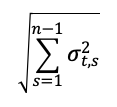

where  
`s` represents a specific stock  
`t` is a particular time_id  
`sigma` is the realized volatility of stock `s` within the time_id `t`  
`n` is the number of stocks  
`n-1` is the number of stocks except `s`  

In [ ]:
def calculate_total_sister_volatility(df_initial_features):

    # Select necessary columns of data to calculate the sister volatility
    selected_columns = {'time_id': "", 
                     'realized_volatility_0': "sum", 
                     'realized_volatility_120': "sum", 
                     'realized_volatility_240': "sum", 
                     'realized_volatility_360': "sum", 
                     'realized_volatility_480': "sum", 
                     'norm_return_by_timeid': "mean"
                   }

    # Calculate aggregate operations
    df_temp = df_initial_features[list(selected_columns.keys())].groupby('time_id', as_index=False, sort=True).agg({k: v for k, v in selected_columns.items() if v != ""})
        
    # Rename columns
    df_temp.rename({col: col + "_sum" for col in df_temp.columns.values[1:-1]}, axis=1, inplace=True)
    df_temp.rename({"norm_return_by_timeid": "norm_market_return_by_timeid"}, axis=1, inplace=True)
        
    # Merge with the main dataframe                                         
    df_initial_features = df_initial_features.merge(df_temp, how="left", on=["time_id"])
    
    # Calculate total sister volatility
    for window in WINDOWS:
        df_initial_features[f"total_sister_volatility_{window}"] = df_initial_features[f"realized_volatility_{window}_sum"] - \
                                                                            df_initial_features[f"realized_volatility_{window}"]
    return df_initial_features

#### _stock pseudo-beta_  

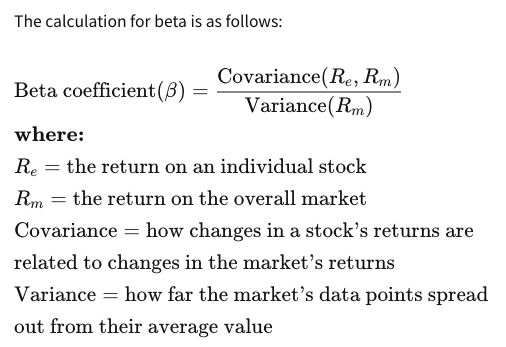  
 
[https://www.investopedia.com/terms/b/beta.asp](http://)

_Note: Since we don't know if the stocks belong to the same stock exchange, and market return on that exchange, this is not a real beta._

In [ ]:
def calculate_pseudo_beta(stock_returns, market_returns, market_return_variance):
 
    # Calculate market return - stock return covariance 
    market_stock_covariance = stock_returns.cov(market_returns)
    
    # Calculate pseudo-beta
    pseudo_beta = market_stock_covariance / market_return_variance
    
    return pseudo_beta

#### _stock correlations_

In [ ]:
def calculate_correlation_matrix(df):

    # Create a pivot table for each window
    df_pivot_0 = df[['stock_id', 'time_id', 'wap1_0_mean']].pivot(index='time_id', columns='stock_id')
    df_pivot_120 = df[['stock_id', 'time_id', 'wap1_120_mean']].pivot(index='time_id', columns='stock_id')
    df_pivot_240 = df[['stock_id', 'time_id', 'wap1_240_mean']].pivot(index='time_id', columns='stock_id')
    df_pivot_360 = df[['stock_id', 'time_id', 'wap1_360_mean']].pivot(index='time_id', columns='stock_id')
    df_pivot_480 = df[['stock_id', 'time_id', 'wap1_480_mean']].pivot(index='time_id', columns='stock_id')
    
    # Calculate correlations for each window
    df_corr_0 = df_pivot_0.corr()
    df_corr_120 = df_pivot_120.corr()
    df_corr_240 = df_pivot_240.corr()
    df_corr_360 = df_pivot_360.corr()
    df_corr_480 = df_pivot_480.corr()
    
    # Create a correlation matrix for the first window for visualization
    corr_matrix_0 = df_corr_0.as_gpu_matrix()
    del df_pivot_0
    del df_pivot_120
    del df_pivot_240
    del df_pivot_360
    del df_pivot_480    

    # Plot correlation matrix
    print('\n')
    print("Correlation matrix", "\n")
    display(df_corr_0.head())
    print('\n')
    plt.figure(figsize = (12,10))
    sns.heatmap(corr_matrix_0, cmap="YlGnBu")
    plt.title("Correlation matrix", fontsize=20)
    plt.xlabel('stock_id', fontsize=15)
    plt.ylabel('stock_id', fontsize=15)
    plt.show()
    print('\n')
    return df_corr_0, df_corr_120, df_corr_240, df_corr_360, df_corr_480


def calculate_stock_correlations(df_corr, number_stocks):

    # Calculate stock correlations
    stock_corrs = {}
    for i in range(number_stocks):
        stock = df_corr.index[i][1]
        values = df_corr.iloc[i:i+1,i:].values.tolist()[0]
        corr = (sum(values)-1) / (number_stocks-1)
        stock_corrs[stock] = corr
    
    return stock_corrs

#### _skewness_

In [ ]:
def calculate_skewness(df):

    for feat in features_list:
        for window in WINDOWS:
            df[f"{feat}_{window}_skew"] = (3 * (df[f"{feat}_{window}_mean"] - df[f"{feat}_{window}_median"])) / df[f"{feat}_{window}_std"]

    return df

#### _schwert model_

In [ ]:
def calculate_schwert_model(df_initial_features):
    
    # Calculate volatility by the model developed by Schwert
    for window in WINDOWS:
        df_initial_features[f"schwert_volatility_{window}"] = np.sqrt((math.pi / 2)) * np.absolute(df_initial_features[f"log_return_{window}_mean"] - \
                                                                                                   df_initial_features["log_return_0_mean"])
    
    return df_initial_features

#### _correlations by second_

In [ ]:
def calculate_correlations(df):

    # Create a schema dataframe
    df_stocks = load_parquet_data("Order Book", 0)
    delete_columns = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']
    df_stocks.drop(delete_columns, axis=1, inplace=True)

    # Calculate wap1 for stocks and fill the dataframe
    for stock_id in tqdm(stock_ids):
        df_stock = load_parquet_data("Order Book", stock_id)
        df_stock[f"wap1_{stock_id}"] = (df_stock['bid_price1'] * df_stock['ask_size1'] + df_stock['ask_price1'] * df_stock['bid_size1']) / \
                            (df_stock['bid_size1'] + df_stock['ask_size1'])
        df_stocks = df_stocks.merge(df_stock[["time_id", "seconds_in_bucket", f"wap1_{stock_id}"]], how="left", on=["time_id", "seconds_in_bucket"])  

    # Save the dataframe
    df_stocks.to_parquet("./wap1s.parquet", compression=None, index=False)    
    
    # Check null values
    x = df_stocks[df_stocks.isna().any(axis=1)]
    print("The number of null rows: ", len(x))
    del x

    # Fill null values with row means
    df_stocks = df_stocks.fillna(df_stocks.iloc[:, 2:].mean(axis=1))

    # Calculate columnwise sum of wap1s across seconds
    df_sum = df_stocks[["time_id", "seconds_in_bucket"]]
    df_sum["wap1_sum"] = df_stocks.iloc[:, 2:].sum(axis=1)
    df_stocks = df_stocks.merge(df_sum[["time_id", "seconds_in_bucket", "wap1_sum"]], how="left", on=["time_id", "seconds_in_bucket"])
    del df_sum

    # The number of total stocks        
    num_of_stocks = len(stock_ids)
    
    # Create a dictionary to store correlations by time_id and stock_id
    corrs = defaultdict(list)
    
    # Calculate mean wap1 across seconds except one stock each time
    for stock_id in tqdm(stock_ids):
        
        df_stocks[f"wap1_sec_mean_{stock_id}"] = (df_stocks["wap1_sum"] - df_stocks[f"wap1_{stock_id}"]) / (num_of_stocks - 1)

        for time_id in time_ids:
            
            s1 = df_stocks[df_stocks["time_id"]==time_id][f"wap1_{stock_id}"]
            s2 = df_stocks[df_stocks["time_id"]==time_id][f"wap1_sec_mean_{stock_id}"]
            corr = s1.corr(s2)
            del s1
            del s2
            corrs["time_id"].append(time_id)
            corrs["stock_id"].append(stock_id)
            corrs["correlation"].append(corr)            

    # Delete uncessary df
    del df_stocks

    # Create a new dataframe from the correlations dictionary
    pdf = pd.DataFrame.from_dict(corrs)                                                                                            
    df_temp = cudf.DataFrame.from_pandas(pdf)
    del corrs
    display(df_temp)

    # Convert dtype
    df_temp['correlation'] = df_temp['correlation'].astype(float32)
        
    # Save the dataframe
    df_temp.to_parquet("./correlations.parquet", compression=None, index=False)

    # Merge with the main dataframe
    df = df.merge(df_temp, how="left", on=["time_id", "stock_id"])
    del df_temp

    # Reorder the columns
    new_cols = [col for col in df.columns if col != 'target'] + ['target']
    df = df[new_cols]     
        
    return df

### **Feature engineering on time_id**

#### Load initial features

In [ ]:
%%time


if PRETRAINED == 2:
    
    df_initial_features = cudf.DataFrame()

    # List pretrained datasets
    pretrained_files = glob.glob("../input/optiver-data/initial_features*")

    # Load files into dataframes
    for pretrained_file in pretrained_files:        
        df_temp = cudf.read_parquet(pretrained_file)
        df_initial_features = df_initial_features.append(df_temp)
        
    # Fill nan values with zero, which will have no impact on the model
    df_initial_features = df_initial_features.fillna(0)
    
    print("\n")
    display(df_initial_features)   
    print("\n")
    display(df_initial_features.info())
    print("\n")

#### Correct the pretrained dataset

In [ ]:
def correct_dataset(df_initial_features):

    # Find the stocks with missing time_ids
    missing_timeids = {}
    for stock_id in tqdm(stock_ids):
        stock_time_ids = df_initial_features[df_initial_features['stock_id']==stock_id]['time_id'].unique().to_array()
        missing_items = [item for item in time_ids if item not in stock_time_ids]
        if len(missing_items) > 0:
            missing_timeids[stock_id] = missing_items

    print(missing_timeids, "\n")

    # Add missing time_ids to the related stocks with the mean values of predictors in that time_id
    df_temp = cudf.DataFrame()
    columns = list(df_initial_features)
    for key, values in missing_timeids.items():
        for value in values:
            df_filtered = df_initial_features.drop("stock_id", axis=1) 
            new_row = df_filtered[df_filtered['time_id']==value].iloc[:,1:].mean().to_array()
            new_row = np.insert(new_row, 0, key)
            new_row = np.insert(new_row, 0, value)
            pdf = pd.DataFrame([new_row], columns=columns)
            cdf = cudf.from_pandas(pdf)
            df_temp = df_temp.append(cdf)

    df_initial_features = df_initial_features.append(df_temp)

    del df_filtered
    del df_temp
    
    return df_initial_features

#### Add new features

In [ ]:
def add_new_features(df_initial_features):

    # Calculate total sister volatility (1)
    df_initial_features = calculate_total_sister_volatility(df_initial_features)
    
    # Calculate stock pseudo-beta (2)
    pseudo_betas = {}
    market_returns = df_initial_features['norm_market_return_by_timeid']

    # Calculate market normal return variance
    market_return_variance = market_returns.var()
    for stock_id in stock_ids:

        # Get norm_return_by_timeid by selected stock
        stock_returns = df_initial_features[df_initial_features['stock_id'] == stock_id]["norm_return_by_timeid"]
        pseudo_beta = calculate_pseudo_beta(stock_returns, market_returns, market_return_variance)
        pseudo_betas[stock_id] = pseudo_beta

    # Create and merge the temporary df
    data = {'stock_id': list(pseudo_betas.keys()), 'pseudo_beta': list(pseudo_betas.values())}
    pdf = pd.DataFrame.from_dict(data)                                                                                            
    df_temp = cudf.DataFrame.from_pandas(pdf)
    df_initial_features = df_initial_features.merge(df_temp, how="left", on=["stock_id"])

    # Calculate correlations (3)
    # Create a new dataframe and sort it
    df_correlations = df_initial_features[['stock_id', 'time_id', 'wap1_0_mean', 'wap1_120_mean', 'wap1_240_mean', 'wap1_360_mean', 'wap1_480_mean']]
    df_correlations = df_correlations.sort_values(["stock_id", "time_id"], ascending=True)

    # Create a correlation matrix for each window
    df_corr_0, df_corr_120, df_corr_240, df_corr_360, df_corr_480 = calculate_correlation_matrix(df_correlations)
    number_stocks = len(df_corr_0)

    # List correlation dataframes
    df_corrs = [df_corr_0, df_corr_120, df_corr_240, df_corr_360, df_corr_480]

    # Calculate average correlation for each stock for each window
    for df_corr in zip(df_corrs, WINDOWS):
        stock_corrs = calculate_stock_correlations(df_corr[0], number_stocks)

        # Reformat the dataframe
        df_correlations = cudf.DataFrame({'stock_id': list(stock_corrs.keys()), f"correlation_{df_corr[1]}": list(stock_corrs.values())})

        # Merge it with the features dataframe
        df_initial_features = df_initial_features.merge(df_correlations, how="left", on=["stock_id"])
        
    # Calculate skewness
    df_initial_features = calculate_skewness(df_initial_features)
    
    # Calculate volatility by the model developed by Schwert    
    df_initial_features = calculate_schwert_model(df_initial_features)
     
    # Delete unused dfs
    del pdf
    del df_temp
    del df_correlations

    return df_initial_features

#### Finalize initial features

In [ ]:
def develop_enhanced_features(df_initial_features):

    # Delete columns
    delete_columns = ['norm_market_return_by_timeid', 'norm_return_by_timeid', 'realized_volatility_0_sum', 'realized_volatility_120_sum', 
                      'realized_volatility_240_sum', 'realized_volatility_360_sum', 'realized_volatility_480_sum'
                     ]
    
    df_initial_features.drop(delete_columns, axis=1, inplace=True)
    
    # Merge train.csv
    df_initial_features = df_initial_features.merge(df_csv, how="left", on=["stock_id", "time_id"])

    # Check null values
    df_temp = df_initial_features[df_initial_features.isna().any(axis=1)]
    print("The number of null rows: ", len(df_temp))
    
    # Filter in only non null rows
    df_initial_features = df_initial_features.dropna(axis=0, subset=['target'])
    df_initial_features.fillna(0, inplace=True)
    
    # Check for clustering
#     df_target_mean_by_stockid = check_clustering(df_initial_features)
    
    # Add stock group if target data can be normalized
#     df_initial_features = scale_data(df_initial_features, df_target_mean_by_stockid)
    
    # Change dtype
    df_initial_features = df_initial_features.astype({'stock_id': 'int16', 'time_id': 'int16'})
    df_initial_features = make_dtype_list(df_initial_features, "float64", "float32")
    df_initial_features = make_dtype_list(df_initial_features, "int64", "int32")
    
    # Sort the data and assign it to the new dataframe
    df_enhanced_features = df_initial_features.sort_values(["time_id", "stock_id"], ascending=True)
 
    # Save the dataframe
    df_enhanced_features.to_parquet("./enhanced_features.parquet", compression=None, index=False)
    
    del df_initial_features
    del df_temp
    
    return df_enhanced_features

#### Develop enhanced features

In [ ]:
%%time


if PRETRAINED == 1 or PRETRAINED == 2:
    if CORRECT_DATASET == "yes":
        
        # Correct dataset
        df_initial_features = correct_dataset(df_initial_features)
        
    # Add new features
    df_initial_features = add_new_features(df_initial_features)
    df_enhanced_features = develop_enhanced_features(df_initial_features)
    
print("\n")
display(df_enhanced_features)   
print("\n")
display(df_enhanced_features.info())
print("\n")

print("Count:", gc.get_count())
collected = gc.collect()
print("Garbage collector: collected %d objects." % (collected))

## **Feature Selection**

#### Load enhanced features

In [ ]:
if PRETRAINED == 3:
    
    # Load dataframe
    df_enhanced_features = cudf.read_parquet("../input/optiver-data/enhanced_features.parquet")

#### Build model for feature selection

In [ ]:
def get_model_for_feature_selection(start, end):

    # Parameters
    params = {
        'objective': 'reg:squarederror',
        'n_estimators' : 10,
        'tree_method': 'gpu_hist',
        'seed' : SEED
    }

    # Instantiation
    model = xgb.XGBRegressor(**params)

    # Fitting the model
    model.fit(X_train.iloc[:, start:end], y_train)
    
    return model

#### Find feature importance

In [ ]:
def calculate_permutation_importance(start, end):
    
    # Get model to select features
    model = get_model_for_feature_selection(start, end)

    # Calculate permutation importance
    result = permutation_importance(model, X_train.iloc[:, start:end], y_train.to_array(), n_repeats=10, random_state=SEED)
    tree_importance_sorted_idx = np.argsort(model.feature_importances_)

    # Store features and their scores
    feature_names = X_train.iloc[:, start:end].columns[tree_importance_sorted_idx].tolist()
    importance_scores = model.feature_importances_[tree_importance_sorted_idx].tolist()
    
    return feature_names, importance_scores

In [ ]:
%%time


if PRETRAINED in list(range(1, 4)):

    # Determine predictors and target
    X = df_enhanced_features.iloc[:, 1:-1]
    y = df_enhanced_features['target']

    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    # Dictionary to store features and scores
    features_list = []
    
    # Number of rounds to run permutation importance
    number_of_features = len(X.columns)
    number_of_rounds = int(number_of_features / 200)
    step_size = math.ceil(number_of_features / number_of_rounds) + 1
    
    # Number of top features to consider in the model
    print('Total number of features to be considered: ', number_of_features)
    print("\n")

    # Find permutation importance of features
    for rnd in tqdm(range(0, number_of_features, step_size)):
        start = rnd
        end = rnd + step_size
        feature_names, importance_scores = calculate_permutation_importance(start, end)
        features_list.extend(zip(feature_names, importance_scores))
    
    # Arrange features and scores
    feats = [x[0] for x in features_list]
    scors = [x[1] for x in features_list]
    features_dict = {"features": feats, "scores": scors}
    
    # Create and sort a dataframe
    df_features = pd.DataFrame.from_dict(features_dict)
    df_features = df_features[df_features['scores'] > 0.0]
    df_features = df_features.sort_values(["scores"], ascending=True)

    # Plot importance features
    df = pd.DataFrame({'scores': df_features['scores'].values.tolist()}, index=df_features['features'].values.tolist())
    df.plot.barh(figsize = (20, 60), title="Feature Importance")
    plt.show()
    print("\n")
    
    # Sort importance dataframe
    df_features = df_features.sort_values(["scores"], ascending=False)
    
    # Save importance dataframe
    df_features.to_parquet("./perm_importance_scores.parquet", compression=None, index=False)
    
    display(df_features)

    del feats
    del scors
    del df

#### Handle multicollinear features

**Plot dendogram**

In [ ]:
def plot_dendogram():
    
    # Plot dendogram
    fig = plt.figure(figsize=(20, 30))

    # Cluster analysis to handle multicollinear features
    corr = spearmanr(X.to_pandas()).correlation
    corr_linkage = hierarchy.ward(corr)
    dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns.tolist(),  leaf_rotation=0, leaf_font_size=10, orientation='left')
    dendro_idx = np.arange(0, len(dendro['ivl']))

    # Threshold line
    plt.vlines(x = t_line, ymin=0, ymax=10000, color = 'r', linestyle = '-')
    fig.tight_layout()
    plt.show()
    print("\n")
    
    # Plot correlation matrix
    fig = plt.figure(figsize=(20, 20))
    plt.imshow(corr[dendro['leaves'], :][:, dendro['leaves']], cmap="viridis")
    plt.xticks(ticks=dendro_idx, labels=dendro['ivl'], rotation='vertical', fontsize=7)
    plt.yticks(ticks=dendro_idx, labels=dendro['ivl'], fontsize=7)
    fig.tight_layout()
    plt.show()
    print("\n")
    
    return corr_linkage

**Find multicollinearity-handled features**

In [ ]:
# Find clusters of features
def get_feature_clusters():
    cluster_ids = hierarchy.fcluster(corr_linkage, t_line, criterion='distance')
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    return cluster_ids, cluster_id_to_feature_ids


# Find the most important feature in each cluster
def find_feature(values):
    cluster_features = {}
    for value in values:
        feat_name = X.columns[value]
        cluster_features[feat_name] = important_features_dict[feat_name]
    best_feature = max(cluster_features, key=cluster_features.get)
    return best_feature


# Create a list of selected most important features
def collect_final_features():
    cluster_ids, cluster_id_to_feature_ids = get_feature_clusters()
    decoll_features = []
    for key, values in cluster_id_to_feature_ids.items():
        best_feature = find_feature(values)
        decoll_features.append(best_feature)
    print("Refined Features:", "\n", "-" * 50)
    display(decoll_features)
    print("\n")
    print("The number of cluster ids: ", len(set(cluster_ids)), "\n")
    print("The number of refined features: ", len(decoll_features), "\n")
    return decoll_features

**Perform final VIF check**

In [ ]:
def calculate_vif(column_list, df):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = column_list
    vif["VIF"] = [variance_inflation_factor(df.to_pandas().values, i) for i in range(len(column_list))]
    display(vif)
    print('\n')
    
    return vif

**Find further reduced features in terms of permutation importance**

In [ ]:
def reduce_features(df_source, df_1):
    
    # Get necessary columns
    if isinstance(df_1, list):
        feature_columns = df_1
    else:
        feature_columns = df_1['features'].tolist()

    # Add stock_id, time_id, and target columns
    feature_columns.append("target")
    feature_columns.insert (0, "time_id")
    if 'stock_id' in feature_columns:
        feature_columns.remove('stock_id')
    feature_columns.insert (1, "stock_id")
    
    # Create new dataframe
    df_2 = df_source[feature_columns]
    
    return df_2


def create_final_df():
    
    # Find the number of records in the importance features dataframe
    number_of_records = len(df_features)
    
    # Find the half of that number
    halfway = math.ceil(number_of_records/2)
    
    # Filter the first half of records
    df_temp = df_features.iloc[0:halfway, :]

    # Get reduced dataframe
    final_features = reduce_features(df_reduced_features, df_temp)
    
    del df_temp
    
    return final_features

**Load and prepare the dataframe**

In [ ]:
%%time


if PRETRAINED == 4:
    
    # Load the main dataframe
    df_enhanced_features = cudf.read_parquet("../input/optiver-data/enhanced_features.parquet")
    
    # Load permutation importance features daaframe
    df_features = cudf.read_parquet("../input/optiver-data/perm_importance_scores.parquet")
    
if PRETRAINED in list(range(1, 5)):    

    # Extract permutation importance features and reduce the main dataframe
    df_reduced_features = reduce_features(df_enhanced_features, df_features)
    
    # Get features data
    X = df_reduced_features.iloc[:, 2:-1]
    
    # Plot dendogram
    t_line = 1
    corr_linkage = plot_dendogram()
    
    # Convert importance features dataframe to dictionary
    records = df_features.to_dict(orient="records")
    important_features_dict = {rec['features']: rec['scores'] for rec in records}
    
    # Get multicollinearity-handled features
    decoll_features = collect_final_features()
    
    # Get multicollinearity-handled features dataframe
    df_decoll_features = reduce_features(df_reduced_features, decoll_features)
    
    # Get further reduced features of df_reduced
    df_final_features = create_final_df()

    # Save the dataframes
    df_reduced_features.to_parquet("./reduced_features.parquet", compression=None, index=False)
    df_final_features.to_parquet("./final_features.parquet", compression=None, index=False)
    df_decoll_features.to_parquet("./decoll_features.parquet", compression=None, index=False)

    del df_reduced_features
    del df_features
    del records
    del important_features_dict
    del df_enhanced_features

## **Model training**

#### Load training dataframes

In [ ]:
def load_dataframes(d):
    
    if PRETRAINED == 5 or PRETRAINED == 6: 
        
        # Dataframes in a dictionary
        dataframes = {1: "../input/optiver-data/final_features.parquet", 
                      2: "../input/optiver-data/decoll_features.parquet", 
                      3: "../input/optiver-data/reduced_features.parquet", 
                      4: "../input/optiver-data/enhanced_features.parquet"}
    
        # Select the dataframe
        dataframe = dataframes[d]
        
        display(dataframe)

    return dataframe

#### Define hyperparameters for optimization

In [ ]:
# Get hyperparameters
def define_hyperparameters(trial):
    
    hyper_params = {
                    "task": 'train',
                    "objective": "regression",
                    "metric": "rmse",
                    "verbosity": -1,
                    "n_jobs": -1,
                    "seed": SEED,
                    "data_random_seed": SEED,
                    "bagging_seed": SEED,
                    "drop_seed": SEED,
                    "num_iterations": 100,
                    "device_type": "gpu",
                    'feature_fraction': 0.8,
                    'feature_fraction_bynode': 0.8,
                    "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
                    "lambda_l1": trial.suggest_int("lambda_l1", 1, 10, step=1),
                    "lambda_l2": trial.suggest_int("lambda_l2", 1, 10, step=1),
                    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.005),
                    "max_depth": trial.suggest_int("max_depth", 8, 12, step=2),
                    "num_leaves": trial.suggest_int("num_leaves", 500, 1000, step=100),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 500, step=100),
                    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0, step=0.1),
                    "bagging_freq": trial.suggest_int("bagging_freq", 30, 70, step=10),
                }
    
    return hyper_params

#### Define the loss function

In [ ]:
# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

#### Tune hyperparameters with CV

In [ ]:
def objective(trial):
    
    # Get the target dataframe
    data = load_dataframes(d)

    # Predictors and target
    X = data.iloc[:, 2:-1]
    y = data['target']
    
    # Get hyperparameters
    hyper_params = define_hyperparameters(trial)
        
    # Model    
    gbm = lgb.LGBMRegressor(**hyper_params)
    
    # Loss scores
    scores = []
    
    # Cross validation
    k = KFold(n_splits = 5, random_state = SEED, shuffle = True)
    for i, (trn_idx, val_idx) in enumerate(k.split(X)):
        
        # Split train, test
        train_x, valid_x = X.iloc[trn_idx, :], X.iloc[val_idx, :]
        train_y, valid_y = y.iloc[trn_idx], y.iloc[val_idx]
        
        # Train the model
        gbm.fit(train_x.as_gpu_matrix(), train_y.to_array(), eval_set = [(valid_x.as_gpu_matrix(), valid_y.to_array())], early_stopping_rounds = 20, verbose = False)
        
        # Predict for training data
        tr_preds = gbm.predict(train_x.as_gpu_matrix())
        tr_score = rmspe(train_y.to_array(), tr_preds)
        
        # Predict for validation data
        val_preds = gbm.predict(valid_x.as_gpu_matrix())
        val_score = rmspe(valid_y.to_array(), val_preds)

        # Collect scores
        scores.append((tr_score, val_score))

    print("\n")
    print(f"RMSPE scores: {scores}")
    print("\n\n")
    
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    # Return mean validation score
    mean_score = scores['validation score'].mean()
    print("Mean validation score: ", mean_score)
    
    return mean_score

#### Find the best hyperparameters

In [ ]:
%%time


# if PRETRAINED in list(range(1, 6)):
if PRETRAINED == 7: # skip this phase
    
    # Target dataframe
    d = 1

    # Run iterations
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=25, n_jobs=-1)

    # Best parameters
    optimized_hparams =  study.best_trial.params

    # Display results
    print("Number of finished trials: {}".format(len(study.trials)))
    print('Best trial:', optimized_hparams)
    print('Best value:', study.best_value)
    print("\n\n\n")

    # Save best parameters
    with open('./optimized_hparams.json', 'w') as fp:
        json.dump(optimized_hparams, fp)
        
    # Optuna visualization of optimization history
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
    print('\n')
    
    # Optuna visualization of slice plot
    fig = optuna.visualization.plot_slice(study)
    fig.show()
    print('\n')
    
    # Optuna visualization of parallel coordinate plot
    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig.show()
    print('\n')

### **Training the best model**

#### Load best hyperparameters

In [ ]:
def declare_hyperparams():
    
    if PRETRAINED == 6:
    
        # Load json file
        with open('../input/optiver-data/final_hparams_0.24102.json') as f:
            optuna_optimized_params = json.load(f)
        print("Hyperparameters optimized by Optuna: ", optuna_optimized_params, "\n")
    
    used_hyperparams = {'task': 'train', 
                        'objective': 'regression',
                        'metric': 'rmse',
                        'verbosity': -1,
                        'n_jobs': -1,
                        'seed': SEED,
                        'bagging_seed': SEED,
                        'data_random_seed': SEED,
                        'drop_seed': SEED,
                        'num_iterations': 200,
                        'device_type': 'gpu',
                        'boosting': 'dart',
                        'lambda_l1': 0,
                        'lambda_l2': 7, 
                        'max_depth': 10,
                        'num_leaves': 800,
                        'learning_rate': 0.05,
                        'min_data_in_leaf': 200,
                        'bagging_fraction': 0.90,
                        'bagging_freq': 30,
                        'feature_fraction': 0.8,
                        'feature_fraction_bynode': 0.8,
                      } 

    # Save used hyperparameters
    with open('./used_hyperparams.json', 'w') as fp:
        json.dump(used_hyperparams, fp)
    print("Selected hyperparameters for training:", used_hyperparams, "\n")
    
    return used_hyperparams

#### Add correlations by seconds

In [ ]:
def add_corrs(df):

    # Load correlations daaframe
    df_corrs = cudf.read_parquet("../input/optiver-data/correlations.parquet")
    
    # Merge with the main dataframe
    df = df.merge(df_corrs, how="left", on=["time_id", "stock_id"])
    
    # Reorder the columns
    new_cols = [col for col in df.columns if col != 'target'] + ['target']
    df = df[new_cols]
    
    del df_corrs
    
    return df

#### Create the datasets

In [ ]:
def split_dataset(data):

    # Define features and target
    X = data.iloc[:, 2:-1]
    y = data['target']
    
    # Split the data
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.30, random_state = SEED)
    
    return X, y, train_x, valid_x, train_y, valid_y

#### Create a Booster instance

In [ ]:
def train_and_evaluate_model():
    
    global valid_x, valid_y
    
    evals_result = {}
    
    # Get best hyperparameters
    used_hyperparams = declare_hyperparams()
    
    # Get the target dataframe
#     data = load_dataframes(d)
    data = add_corrs(df_final_features)
    
    # Split the dataframe
    X, y, train_x, valid_x, train_y, valid_y = split_dataset(data)
    
    # Find feature names
    feature_names = X.columns.tolist()
    
    # Create train and validation datasets for the ML method selected
    dtrain = lgb.Dataset(train_x.as_gpu_matrix(), label=train_y.to_array(), feature_name=feature_names)
    dvalid = lgb.Dataset(valid_x.as_gpu_matrix(), valid_y.to_array(), reference=dtrain, feature_name=feature_names)
    
    # Train the model
    booster = lgb.train(used_hyperparams, 
                        train_set=dtrain,
                        valid_sets=dvalid,
                        num_boost_round=300,
                        early_stopping_rounds=30,
                        evals_result=evals_result,
                        verbose_eval=100)
    
    return booster, evals_result, feature_names

#### Save and plot the model

In [ ]:
def save_and_plot_model():
    
    # Train and evaluate the model
    booster, evals_result, feature_names = train_and_evaluate_model()
    
    # Save the best model
    booster.save_model(f"./lgb_{d}.model", num_iteration=booster.best_iteration)
    
    # Plot functionality
    # Plot metric
    lgb.plot_metric(evals_result, metric="rmse", figsize=(12, 8))
    plt.title("Loss metric")
    plt.show()
    print('\n')
    
    # Plot importance
    height = math.ceil(len(feature_names) / 4)
    lgb.plot_importance(booster, figsize=(12, height))
    plt.title("Feature importance")
    plt.show()
    print('\n')
    
    # Minimum RMSE
    min_rmse = min(evals_result['valid_0']['rmse'])
    
    print("Minimum RMSE for the dataframe {d}:", min_rmse, "\n")
    
    return booster, min_rmse

In [ ]:
%%time


if PRETRAINED in list(range(1, 7)):
    
    # Target dataframe
    d = 1
    
    # LGBMs
    boosters = {}

    print(f"Summary and results for the dataframe {d}")
    print("-" * 40)

    boosters[d] = save_and_plot_model()

#### Predict

In [ ]:
%%time


if PRETRAINED in list(range(1, 7)):

    # Model
    lgbm_model = boosters[d][0]

    # Predict
    ypred = lgbm_model.predict(valid_x.as_gpu_matrix(), num_iteration=lgbm_model.best_iteration)

    # Loss
    rmspe_loss = rmspe(valid_y.to_array(), ypred)

    print(f"Loss of the model lgbm for the dataframe {d}: {rmspe_loss}")